In [ ]:
!pip install shap
!pip install pandas==1.2.0
!pip install --upgrade xlrd
!pip install --upgrade pandas

## Install and Import Necessary Packages

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Organize Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get file names to upload
dir_idx: str = "/content/drive/MyDrive/BetAIData/2000.xls"
df = pd.read_excel(dir_idx)
features: list = ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Round', 'Best of', 
                  'Winner', "Loser", 'Surface', 'WRank', 'LRank', "Wsets", 'Lsets', "Comment"]              
df = df[features]

for i in tqdm(range(2001, 2023)): 
  if i < 2013: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xls"
  else: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xlsx"
  
  df_add = pd.read_excel(dir_idx)
  df_add = df_add[features]
  df = pd.concat([df, df_add])

 55%|█████▍    | 12/22 [00:03<00:03,  3.11it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 59%|█████▉    | 13/22 [00:05<00:05,  1.63it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 64%|██████▎   | 14/22 [00:06<00:06,  1.16it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 68%|██████▊   | 15/22 [00:07<00:07,  1.00s/it]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 22/22 [00:16<00:00,  1.35it/s]


In [ ]:
df = df[df['Comment'] == 'Completed']

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61296 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         61296 non-null  int64         
 1   Location    61296 non-null  object        
 2   Tournament  61296 non-null  object        
 3   Date        61296 non-null  datetime64[ns]
 4   Series      61296 non-null  object        
 5   Court       61296 non-null  object        
 6   Round       61296 non-null  object        
 7   Best of     61281 non-null  float64       
 8   Winner      61296 non-null  object        
 9   Loser       61296 non-null  object        
 10  Surface     61296 non-null  object        
 11  WRank       61276 non-null  object        
 12  LRank       61191 non-null  object        
 13  Wsets       61008 non-null  float64       
 14  Lsets       61006 non-null  float64       
 15  Comment     61296 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
df['Best of'].value_counts()

3.0    49642
5.0    11639
Name: Best of, dtype: int64

<ipython-input-56-dc239bdebb06>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_tbl = df.corr()


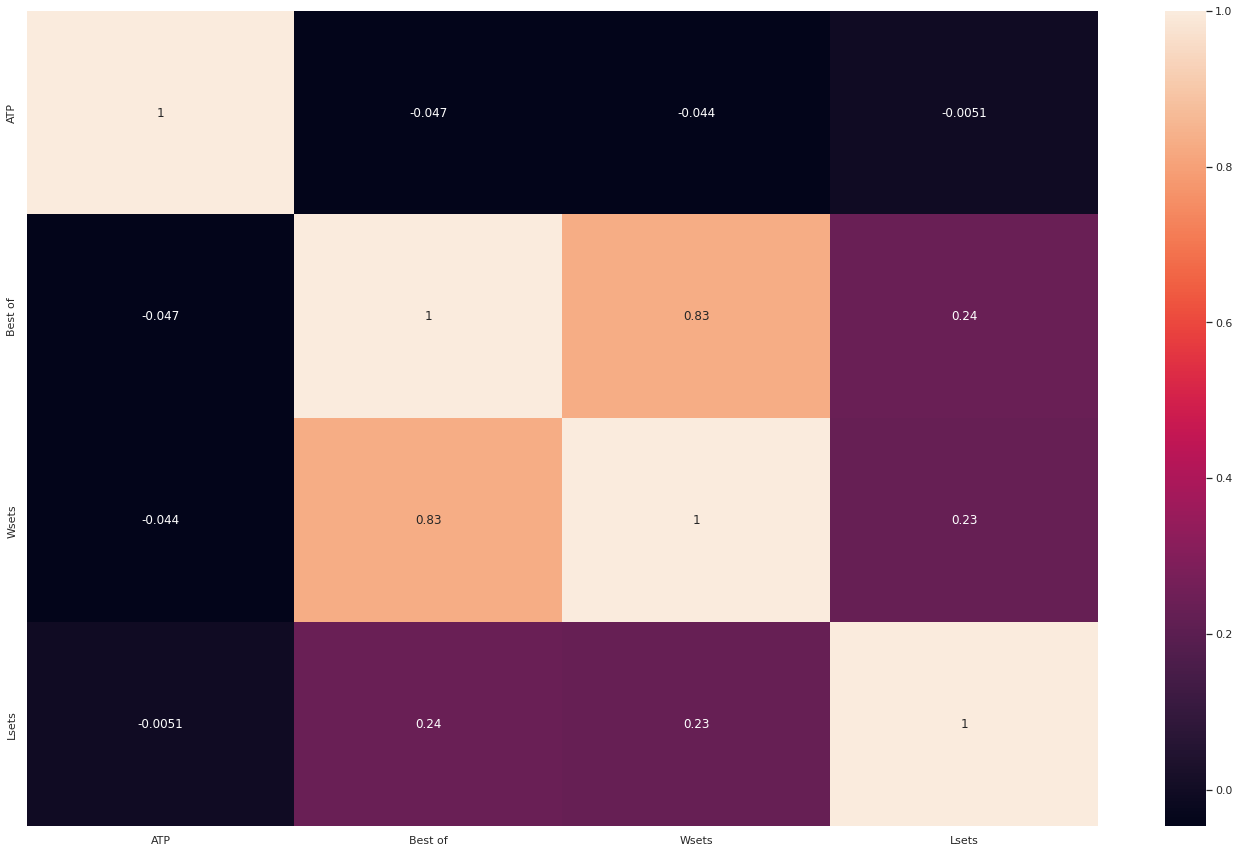

In [ ]:
# find feature correlations
corr_tbl = df.corr()

sns.set(rc={'figure.figsize':(24,15)})
sns.heatmap(corr_tbl, annot=True)

## Data Preprocessing

In [ ]:
# remove correlated columns automatically
corr_df = df.corr()

# get all items above 0.5 correlation and drop them from dataframe 
try: 
  df.drop(['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'], axis=1, inplace=True)
except KeyError: 
  pass
  
df.info()

<ipython-input-362-3a2fb4903ef4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59081 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         59081 non-null  int64         
 1   Location    59081 non-null  object        
 2   Tournament  59081 non-null  object        
 3   Date        59081 non-null  datetime64[ns]
 4   Series      59081 non-null  object        
 5   Court       59081 non-null  object        
 6   Round       59081 non-null  object        
 7   Best of     59066 non-null  float64       
 8   Winner      59081 non-null  object        
 9   Loser       59081 non-null  object        
 10  Surface     59081 non-null  object        
 11  WRank       59061 non-null  object        
 12  LRank       58979 non-null  object        
 13  Wsets       59080 non-null  float64       
 14  Lsets       59080 non-null  float64       
 15  Comment     59081 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
# check nan values
df.isnull().sum()
length = df.shape[0]
nan_prev_threshold: float = 85

null_df = df.isnull().sum()
for col in df.columns:
  null_df[f'{col}_percent'] = (null_df[col]/length)*100
null_df.drop(df.columns, inplace=True)

null_df_refined = pd.DataFrame(columns=['feature', 'nan_prevalence'])
null_df_refined['feature'] = null_df.index
null_df_refined['nan_prevalence'] = null_df.values
null_df_refined = null_df_refined[null_df_refined['nan_prevalence'] < nan_prev_threshold]
null_df_refined.reset_index(inplace=True, drop=True)
features: list = list(null_df_refined['feature'])
features = [col.replace('_percent', '') for col in features]

In [ ]:
df = df[features]
df.shape

(59081, 16)

## Feature Engineering

## Run Once

In [ ]:
try: 
  df.drop(['Date', 'Comment'], inplace=True, axis=1)
except KeyError: 
  pass

In [ ]:
# remove nans from sets
df = df[~df['Wsets'].isna()]
df = df[~df['Lsets'].isna()]

In [ ]:
df = df[df['Wsets'] != 'NR']
df = df[df['Lsets'] != 'NR']
df = df[df['LRank'] != 'NR']
df = df[df['WRank'] != 'NR']

In [ ]:
df['target_w'] = df['Wsets']
df['target_l'] = df['Lsets']

## Variable Encoding

In [ ]:
# encoding for tournament
tourn_encoder = LabelEncoder()
df['Tournament'] = tourn_encoder.fit_transform(df['Tournament'].astype(str))

# encoder for location
loc_encoder = LabelEncoder()
df['Location'] = loc_encoder.fit_transform(df['Location'].astype(str))

# series encoder
ser_encoder = LabelEncoder()
df['Series'] = ser_encoder.fit_transform(df['Series'].astype(str))

# court encoder
court_encoder = LabelEncoder()
df['Court'] = court_encoder.fit_transform(df['Court'].astype(str))

# round encoder
round_encoder = LabelEncoder()
df['Round'] = round_encoder.fit_transform(df['Round'].astype(str))

# surface encoder
surf_encoder = LabelEncoder()
df['Surface'] = surf_encoder.fit_transform(df['Surface'].astype(str))

# winner and loser encoder
winner_encoder = LabelEncoder()
df['Winner'] = winner_encoder.fit_transform(df['Winner'].astype(str))
loser_encoder = LabelEncoder()
df['Loser'] = loser_encoder.fit_transform(df['Loser'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59054 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         59054 non-null  int64  
 1   Location    59054 non-null  int64  
 2   Tournament  59054 non-null  int64  
 3   Series      59054 non-null  int64  
 4   Court       59054 non-null  int64  
 5   Round       59054 non-null  int64  
 6   Best of     59039 non-null  float64
 7   Winner      59054 non-null  int64  
 8   Loser       59054 non-null  int64  
 9   Surface     59054 non-null  int64  
 10  WRank       59034 non-null  object 
 11  LRank       58952 non-null  object 
 12  Wsets       59054 non-null  float64
 13  Lsets       59054 non-null  float64
 14  target_w    59054 non-null  float64
 15  target_l    59054 non-null  float64
dtypes: float64(5), int64(9), object(2)
memory usage: 7.7+ MB


In [ ]:
# imputer handling nan values
df_imputed = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()  
df['target_w'] = df['target_w'].astype(int)
df['target_l'] = df['target_l'].astype(int)

## Predictive Model

In [ ]:
# define train-test data (70-30 proportion)
df = df.sample(frac=1)
y = df[['target_w', 'target_l']]
X = df.drop(['target_w', 'target_l'], axis=1)
for col in X.columns: 
  X[col] = X[col].astype(float)
X.drop(['Wsets', 'Lsets'], inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [ ]:
selector = RFE(XGBClassifier(), n_features_to_select=5, step=1)
selector.fit(X, y['target_w'])
print(selector.ranking_)
selector = RFE(XGBClassifier(), n_features_to_select=5, step=1)
selector.fit(X, y['target_l'])
print(selector.ranking_)

In [ ]:
# XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train['target_w'])
preds_w = model.predict(X_test)

# XGBoost model
model = XGBClassifier(n_estimators=25)
model.fit(X_train, y_train['target_l'])
preds_l = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
accuracy_score(y_test['target_w'], preds_w)

0.9994919928395182

In [ ]:
accuracy_score(y_test['target_l'], preds_l)

0.6198413082393923

In [ ]:
from collections import Counter

arr = []

for w, l in zip(preds_w, preds_l): 
  # get winner 
  if w > l: 
    pred_winner = 1
  else: 
    pred_winner = 0
  
  arr.append(pred_winner)

Counter(arr)

Counter({1: 41338})

## Updated Game-by-Game Model

In [ ]:
!pip install imbalanced-learn

In [ ]:
df = pd.read_csv('drive/MyDrive/BetAIData/ATP/TennisBets6.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df['Sets1'] = df['Sets1'].astype(int)
df['Sets2'] = df['Sets2'].astype(int)
df['RankD'] = abs(df['LRank'] - df['WRank'])
df['SetS'] = df['Sets1'] + df['Sets2'] 
df.drop(['Sets1', 'Sets2'], inplace=True, axis=1)
df = df[df['Best of'] == 5.0]

In [ ]:
df['Target'] = df["SetS"] > 4.5
df['Target'] = df['Target'].astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

df.dropna(inplace=True)
X = df.drop(['Target', 'SetS', 'Best of'], axis=1)
y = df[['Target']]

# oversample with SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.1, stratify=y)

model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
print(scores)
model.fit(X_train, y_train)
preds = model.predict(X_test)
roc_auc_score(preds, y_test)

Target
0         9362
1         9362
dtype: int64
[0.58817523 0.57498985 0.79173907 0.86093666 0.8745634  0.87504166
 0.86489494 0.85271991 0.86092677 0.86018941]


0.7265142763795055

<BarContainer object of 11 artists>

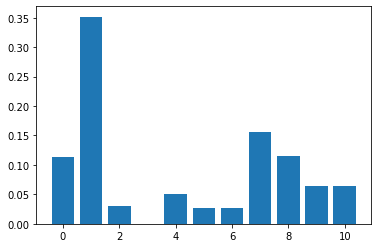

In [ ]:
import matplotlib.pyplot as plt 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [ ]:
probs_pred = model.predict_proba(X_test)
confidence = 0.7

correct, incorrect, skipped = 0, 0, 0

for arr_prob, actual in zip(probs_pred, y_test.values): 
  prob = arr_prob[np.argmax(arr_prob)]
  pred = np.argmax(arr_prob)

  if prob > confidence: 
    if pred == actual[0]: 
      correct += 1
    else: 
      incorrect += 1
  else: 
    skipped += 1

print(correct / (incorrect + correct))
print(skipped / len(y_test))

0.9267886855241264
0.6791243993593166


In [ ]:
X

,Location,Tournament,Series,Court,Round,P1,P2,Surface,WRank,LRank,RankD
0,66,25,2,1,0,7,1153,3,1.000000,112.000000,111.000000
1,66,25,2,1,0,18,884,3,35.000000,107.000000,72.000000
2,66,25,2,1,0,55,29,3,41.000000,111.000000,70.000000
3,66,25,2,1,0,113,938,3,106.000000,28.000000,78.000000
4,66,25,2,1,0,141,1385,3,76.000000,81.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...
18719,56,248,2,1,0,517,1525,2,200.973728,30.127144,170.846584
18720,56,248,2,1,0,310,1019,2,16.554523,105.497981,88.943458
18721,64,244,2,1,1,783,1094,2,24.380668,31.477328,14.606377
18722,80,239,2,1,2,443,1005,3,23.429400,12.728607,23.113386
